In [7]:
import pandas as pd
import re
from sklearn.utils import resample

# Load the dataset
file_path = '/Users/athukoralagekavishanvishwajith/Desktop/AIDS/Year2/DSGP/InvestHERE/Untitled/sentiment/Data/News_Data/News_Data_prePoroccess/sinhala_news_sentiment.csv'
data = pd.read_csv(file_path)

# 1. Remove unnecessary columns
if '__index_level_0__' in data.columns:
    data = data.drop(columns=['__index_level_0__'])

# 2. Clean text (remove special characters, extra spaces)
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

data['comment'] = data['comment'].astype(str).apply(clean_text)

# 3. Ensure consistent label mapping
label_map = {
    0: 'negative',
    1: 'neutral',
    2: 'positive'
}
data['simplified_label'] = data['label'].map(label_map)

# 4. Balance the dataset (optional, if imbalance exists)
min_size = data['label'].value_counts().min()

balanced_data = pd.concat([
    resample(data[data['label'] == 0], n_samples=min_size, random_state=42),
    resample(data[data['label'] == 1], n_samples=min_size, random_state=42),
    resample(data[data['label'] == 2], n_samples=min_size, random_state=42)
])

# 5. Save the cleaned dataset
output_file = 'cleaned_dataset.csv'
balanced_data.to_csv(output_file, index=False)

print(f"Cleaned dataset saved to: {output_file}")
print(balanced_data['simplified_label'].value_counts())


Cleaned dataset saved to: cleaned_dataset.csv
simplified_label
negative    2403
neutral     2403
positive    2403
Name: count, dtype: int64


In [8]:

import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch

# Load cleaned data
file_path = "cleaned_dataset.csv"
data = pd.read_csv(file_path)

# Map labels to numerical values
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
data['encoded_label'] = data['simplified_label'].map(label_map)

# Split into train and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)
print(f"Training size: {len(train_data)}, Validation size: {len(val_data)}")


Training size: 5767, Validation size: 1442


In [9]:
tokenizer = AutoTokenizer.from_pretrained("NLPC-UOM/SinBERT-large")

# Tokenization function
def tokenize_data(data, text_column):
    return tokenizer(
        list(data[text_column]),
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors='pt'
    )

# Tokenize train and validation sets
train_encodings = tokenize_data(train_data, 'comment')
val_encodings = tokenize_data(val_data, 'comment')


In [10]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create datasets
train_dataset = SentimentDataset(train_encodings, train_data['encoded_label'].tolist())
val_dataset = SentimentDataset(val_encodings, val_data['encoded_label'].tolist())


In [11]:
model = AutoModelForSequenceClassification.from_pretrained("NLPC-UOM/SinBERT-large", num_labels=3)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at NLPC-UOM/SinBERT-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    save_strategy="epoch",
    load_best_model_at_end=True
)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()


/var/folders/tr/fzn4ndsx0j3dlwk6s_7rqfkh0000gn/T/ipykernel_61846/881774014.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,1.029700,0.929005
2,0.884200,0.913033
3,0.640000,0.926046


/var/folders/tr/fzn4ndsx0j3dlwk6s_7rqfkh0000gn/T/ipykernel_61846/881774014.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/var/folders/tr/fzn4ndsx0j3dlwk6s_7rqfkh0000gn/T/ipykernel_61846/881774014.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/var/folders/tr/fzn4ndsx0j3dlwk6s_7rqfkh0000gn/T/ipykernel_61846/881774014.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key

TrainOutput(global_step=2163, training_loss=0.8188057069253767, metrics={'train_runtime': 2676.8806, 'train_samples_per_second': 6.463, 'train_steps_per_second': 0.808, 'total_flos': 1138031310028032.0, 'train_loss': 0.8188057069253767, 'epoch': 3.0})

In [14]:
model.save_pretrained("./fine_tuned_sinbert")
tokenizer.save_pretrained("./fine_tuned_sinbert")


('./fine_tuned_sinbert/tokenizer_config.json',
 './fine_tuned_sinbert/special_tokens_map.json',
 './fine_tuned_sinbert/vocab.json',
 './fine_tuned_sinbert/merges.txt',
 './fine_tuned_sinbert/added_tokens.json',
 './fine_tuned_sinbert/tokenizer.json')

In [15]:
results = trainer.evaluate()
print(results)


/var/folders/tr/fzn4ndsx0j3dlwk6s_7rqfkh0000gn/T/ipykernel_61846/881774014.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'eval_loss': 0.9130333662033081, 'eval_runtime': 62.4381, 'eval_samples_per_second': 23.095, 'eval_steps_per_second': 2.899, 'epoch': 3.0}


In [16]:
from sklearn.metrics import classification_report

# Get model predictions on the validation set
predictions = trainer.predict(val_dataset)
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), axis=1)

# Generate the report
print(classification_report(val_data['encoded_label'], predicted_labels))


/var/folders/tr/fzn4ndsx0j3dlwk6s_7rqfkh0000gn/T/ipykernel_61846/881774014.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


              precision    recall  f1-score   support

           0       0.56      0.53      0.55       502
           1       0.54      0.74      0.62       475
           2       0.76      0.52      0.62       465

    accuracy                           0.60      1442
   macro avg       0.62      0.60      0.60      1442
weighted avg       0.62      0.60      0.60      1442



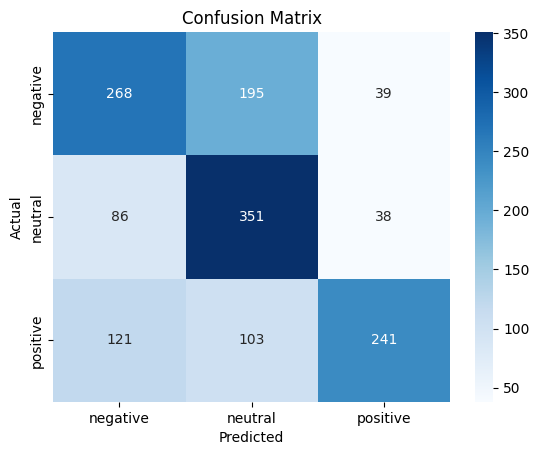

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(val_data['encoded_label'], predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [18]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',
    save_strategy="epoch",
    load_best_model_at_end=True
)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [21]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset # Example: adjusting weight for class 0 and 2
)

trainer.train()

/var/folders/tr/fzn4ndsx0j3dlwk6s_7rqfkh0000gn/T/ipykernel_61846/881774014.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,1.146800,1.117194
2,1.130000,1.105148
3,1.113500,1.099057
4,1.108900,1.094745
5,1.104500,1.091449


/var/folders/tr/fzn4ndsx0j3dlwk6s_7rqfkh0000gn/T/ipykernel_61846/881774014.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/var/folders/tr/fzn4ndsx0j3dlwk6s_7rqfkh0000gn/T/ipykernel_61846/881774014.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/var/folders/tr/fzn4ndsx0j3dlwk6s_7rqfkh0000gn/T/ipykernel_61846/881774014.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key

TrainOutput(global_step=3605, training_loss=1.1194203645280263, metrics={'train_runtime': 4293.9112, 'train_samples_per_second': 6.715, 'train_steps_per_second': 0.84, 'total_flos': 1896718850046720.0, 'train_loss': 1.1194203645280263, 'epoch': 5.0})

In [22]:
from sklearn.metrics import classification_report

# Get model predictions on the validation set
predictions = trainer.predict(val_dataset)
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), axis=1)

# Generate the report
print(classification_report(val_data['encoded_label'], predicted_labels))


/var/folders/tr/fzn4ndsx0j3dlwk6s_7rqfkh0000gn/T/ipykernel_61846/881774014.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       502
           1       0.33      1.00      0.50       475
           2       0.91      0.02      0.04       465

    accuracy                           0.34      1442
   macro avg       0.41      0.34      0.18      1442
weighted avg       0.40      0.34      0.18      1442



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  